In [1]:
import time

import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


,F,G,S
2012-01-04 00:00:00,-0.014730,0.005067,0.001569
2012-01-05 00:00:00,0.006770,0.006828,0.002662
2012-01-06 00:00:00,-0.014570,-0.003676,-0.002577
2012-01-09 00:00:00,0.021325,-0.004453,0.002427
2012-01-10 00:00:00,0.022550,0.013674,0.008671


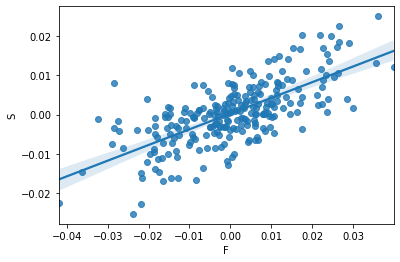

In [2]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df, v["ret"]] , axis = 1)
    
ret_df.columns = data.keys()
display(ret_df.head())
sns.regplot(x="F", y="S", data=ret_df)

observation_index_points_ =  ret_df["F"].values.reshape(-1,1)
observations_ = ret_df["S"].values

# 1. Construct Model

# 1.1 Define the model

In [3]:
def build_gp(amplitude, length_scale, observation_noise_variance):

    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})



## 1.2 Constrain the parameters

In [4]:
# Constraining parameters to positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]


## 1.3 Define the log prob

In [5]:
# Define the log probability

@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

# 2 Train the Model

In [6]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = -target_log_prob(amplitude_var, length_scale_var,observation_noise_variance_var)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Trained parameters:
amplitude: 0.14000620072953063
length_scale: 0.36128027489701664
observation_noise_variance: 8.348527861969241e-05


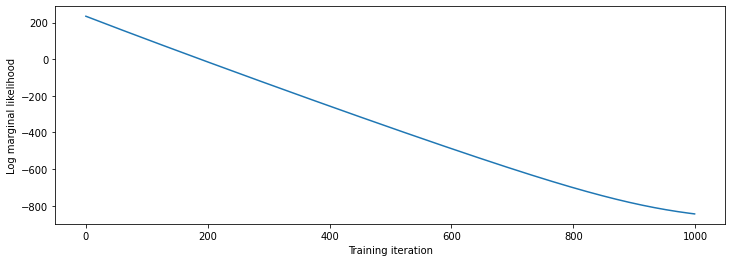

In [7]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

# 3. Generate Predictions

In [19]:

predictive_index_points_ = np.linspace(np.min(observation_index_points_),np.max(observation_index_points_), 100 )
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

num_samples = 100
samples = gprm.sample(num_samples)

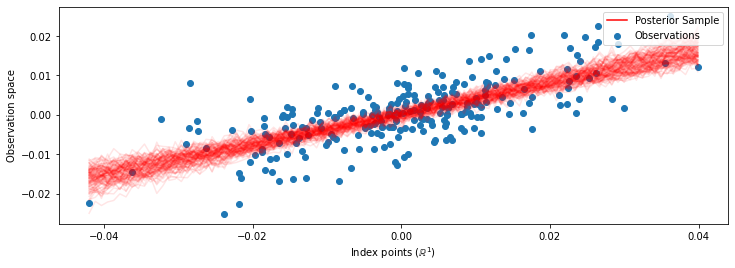

In [20]:

plt.figure(figsize=(12, 4))
plt.scatter(observation_index_points_[:, 0], observations_, label='Observations')
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
             label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()